In [1]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric

Looking in links: file:///kaggle/input/torch-geometric
Processing /kaggle/input/torch-geometric/torch_scatter-2.1.1-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_sparse-0.6.17-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_cluster-1.6.1-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_spline_conv-1.2.2-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_geometric-2.3.1-py3-none-any.whl


In [28]:
!pip install pyg-lib -f https://data.pyg.org/whl/torch-2.0.0+cu117.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.1 MB/s eta 0:00:0000:010:01


In [3]:
import os
import json
import re
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from torch_sparse import SparseTensor
from torch_geometric.nn import GCNConv
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import SAGEConv, to_hetero

import torch_geometric.transforms as T
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'USING: {device}')
print(f'CUDA Version: {torch.version.cuda}')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


USING: cuda
CUDA Version: 11.8


In [5]:
restaurants = pd.read_feather('/kaggle/input/yelp-restaurant/yelp_restaurants.feather')
reviews = pd.read_feather('/kaggle/input/yelp-restaurant/yelp_restaurants_reviews.feather')

In [6]:
reviews['datetime'] = pd.to_datetime(reviews['date'])
reviews_sub = reviews[reviews.datetime.dt.year == 2018].reset_index(drop=True)

# YELP 2018 only

In [7]:
rest = restaurants[restaurants.business_id.isin(reviews_sub.business_id.unique())].reset_index(drop=True)
rest.drop(['address', 'state', 'postal_code', 'hours'], axis='columns', inplace=True)

In [8]:
rest.head()

,business_id,name,city,latitude,longitude,stars,review_count,is_open,attributes,categories
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,39.955505,-75.155564,4.0,80.0,1.0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,Ashland City,36.269593,-87.058943,2.0,6.0,1.0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Burgers, Fast Food, Sandwiches, Food, Ice Crea..."
2,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,Nashville,36.208102,-86.768170,1.5,10.0,1.0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,..."
3,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,Tampa Bay,27.955269,-82.456320,4.0,10.0,1.0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Vietnamese, Food, Restaurants, Food Trucks"
4,il_Ro8jwPlHresjw9EGmBg,Denny's,Indianapolis,39.637133,-86.127217,2.5,28.0,1.0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","American (Traditional), Restaurants, Diners, B..."


In [9]:
# Extract unique restaurant and user IDs and create a dictionary mapping them to indices
restaurant_ids = rest['business_id'].unique().tolist()
num_restaurants = len(restaurant_ids)
restaurant_indices = dict(zip(restaurant_ids, range(num_restaurants)))

user_ids = reviews_sub['user_id'].unique().tolist()
num_users = len(user_ids)
user_indices = dict(zip(user_ids, range(num_users)))

In [10]:
rest.insert(loc=1, column="mapped_business_id", value=rest.business_id.map(restaurant_indices))

In [11]:
reviews_merged = reviews_sub.merge(rest[['business_id']], on='business_id', how='inner')

In [12]:
# Encode IDs
reviews_merged.insert(loc=3, column='mapped_user_id', value=reviews_merged.user_id.map(user_indices))
reviews_merged.insert(loc=4, column='mapped_business_id', value=reviews_merged.business_id.map(restaurant_indices))

In [13]:
reviews_merged.head()

,review_id,user_id,business_id,mapped_user_id,mapped_business_id,stars,useful,funny,cool,text,date,datetime
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,0,388,3.0,0.0,0.0,0.0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,2018-07-07 22:09:11
1,uyS0ysaMd4mzw5rNYbgcjA,ql0XsKTjM7VeBAUqbphQDw,XQfwVwDr-v0ZS3_CbbE5Xw,1878,388,3.0,0.0,0.0,0.0,"Food is fantastic, service is quite awful! Ca...",2018-03-24 17:50:37,2018-03-24 17:50:37
2,R10wk4xEHX9r-qs5Z_2vvw,ZeBgfIMxp9K8OFmlXmQ3yA,XQfwVwDr-v0ZS3_CbbE5Xw,5139,388,3.0,0.0,0.0,0.0,Update: I deducted a star because they no long...,2018-07-21 09:26:33,2018-07-21 09:26:33
3,pDN3hRBarmGWXbK64A83MA,IBrReMAeZkVIbjZIe1E_Hw,XQfwVwDr-v0ZS3_CbbE5Xw,7057,388,1.0,0.0,0.0,0.0,never coming back here again. all of the glass...,2018-09-08 17:03:53,2018-09-08 17:03:53
4,HxWtq5q4OQ-4osStqn54bA,k4_8Cw2icH0nFV5MskGK1A,XQfwVwDr-v0ZS3_CbbE5Xw,12935,388,2.0,0.0,0.0,0.0,Unfortunately the weekend chef doesn't know ho...,2018-09-09 14:30:29,2018-09-09 14:30:29


In [14]:
rest.head()

,business_id,mapped_business_id,name,city,latitude,longitude,stars,review_count,is_open,attributes,categories
0,MTSW4McQd7CbVtyjqoe9mw,0,St Honore Pastries,Philadelphia,39.955505,-75.155564,4.0,80.0,1.0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
1,CF33F8-E6oudUQ46HnavjQ,1,Sonic Drive-In,Ashland City,36.269593,-87.058943,2.0,6.0,1.0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Burgers, Fast Food, Sandwiches, Food, Ice Crea..."
2,bBDDEgkFA1Otx9Lfe7BZUQ,2,Sonic Drive-In,Nashville,36.208102,-86.768170,1.5,10.0,1.0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,..."
3,eEOYSgkmpB90uNA7lDOMRA,3,Vietnamese Food Truck,Tampa Bay,27.955269,-82.456320,4.0,10.0,1.0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Vietnamese, Food, Restaurants, Food Trucks"
4,il_Ro8jwPlHresjw9EGmBg,4,Denny's,Indianapolis,39.637133,-86.127217,2.5,28.0,1.0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","American (Traditional), Restaurants, Diners, B..."


In [15]:
cat_dummy = pd.Series(rest['categories']).str.get_dummies(', ')
cat_dummy

,Acai Bowls,Accessories,Accountants,Active Life,Acupuncture,Adult,Adult Education,Adult Entertainment,Advertising,Afghan,...,Wine & Spirits,Wine Bars,Wine Tasting Classes,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Wraps,Yelp Events,Yoga
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

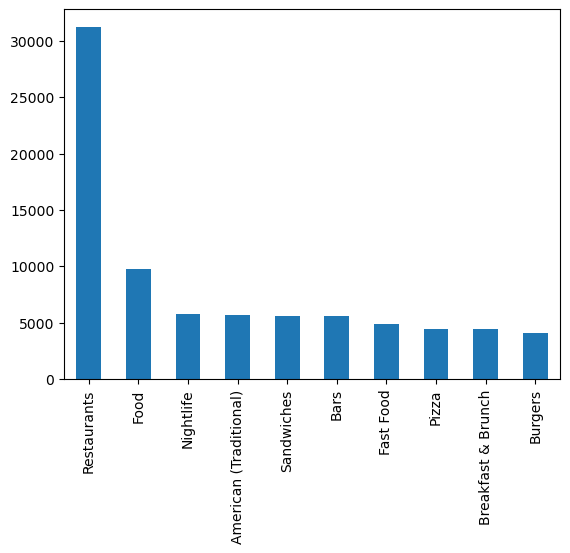

In [16]:
rest.categories.str.split(', ').explode().value_counts()[:10].plot(kind="bar")

In [17]:
rest_features = pd.concat([rest[['stars', 'review_count', 'is_open']], cat_dummy], axis=1)
rest_features.drop(columns=['Restaurants', 'Food'],inplace=True,axis=1)

In [18]:
rest_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31217 entries, 0 to 31216
Columns: 641 entries, stars to Yoga
dtypes: float64(3), int64(638)
memory usage: 152.7 MB


In [19]:
rest_features.describe()

,stars,review_count,is_open,Acai Bowls,Accessories,Accountants,Active Life,Acupuncture,Adult,Adult Education,...,Wine & Spirits,Wine Bars,Wine Tasting Classes,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Wraps,Yelp Events,Yoga
count,31217.000000,31217.000000,31217.000000,31217.000000,31217.000000,31217.000000,31217.000000,31217.000000,31217.000000,31217.000000,...,31217.000000,31217.000000,31217.000000,31217.000000,31217.000000,31217.000000,31217.000000,31217.000000,31217.000000,31217.000000
mean,3.500400,124.671333,0.810360,0.003171,0.000128,0.000064,0.007304,0.000032,0.000032,0.000032,...,0.024346,0.020566,0.000096,0.000801,0.000128,0.002050,0.000288,0.006343,0.000192,0.000288
std,0.819602,233.986358,0.392023,0.056226,0.011319,0.008004,0.085150,0.005660,0.005660,0.005660,...,0.154123,0.141927,0.009803,0.028288,0.011319,0.045233,0.016977,0.079389,0.013863,0.016977
min,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,24.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.500000,57.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,139.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,7568.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
rest_features

,stars,review_count,is_open,Acai Bowls,Accessories,Accountants,Active Life,Acupuncture,Adult,Adult Education,...,Wine & Spirits,Wine Bars,Wine Tasting Classes,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Wraps,Yelp Events,Yoga
0,4.0,80.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,6.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.5,10.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,10.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.5,28.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31212,3.0,11.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31213,4.0,33.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31214,4.5,35.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31215,4.5,14.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
rest_feature_np = rest_features.to_numpy()

In [22]:
rest_feature_np.shape

(31217, 641)

In [23]:
edge_index = torch.stack(
    [torch.from_numpy(reviews_merged.mapped_user_id.values), torch.from_numpy(reviews_merged.mapped_business_id.values)],
    dim=0
)

data = HeteroData()

data['user'].node_id = torch.arange(len(reviews_merged.mapped_user_id.unique()))
data['restaurant'].node_id = torch.arange(len(reviews_merged.mapped_business_id.unique()))
data['restaurant'].x = rest_feature_np

data['user', 'rating', 'restaurant'].edge_index = edge_index
data['user', 'rating', 'restaurant'].edge_label = torch.from_numpy(reviews_merged.stars.values)

data = T.ToUndirected()(data)
del data['restaurant', 'rev_rating', 'user'].edge_label 

In [24]:
data

HeteroData(
  user={ node_id=[290714] },
  restaurant={
    node_id=[31217],
    x=[31217, 641]
  },
  (user, rating, restaurant)={
    edge_index=[2, 596895],
    edge_label=[596895]
  },
  (restaurant, rev_rating, user)={ edge_index=[2, 596895] }
)

In [25]:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=0.0,
    add_negative_train_samples=False,
    edge_types=("user", "rating", "restaurant"),
    rev_edge_types=("restaurant", "rev_rating", "user"), 
)

train_data, val_data, test_data = transform(data)

In [27]:

# Define the training seed changes
edge_label_index = train_data["user", "rating", "restaurant"].edge_label_index
edge_label = train_data["user", "rating", "restaurant"].edge_label
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
#     neg_sampling_ratio=0.0,
    edge_label_index=(("user", "rating", "restaurant"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Define the validation seed edges:
edge_label_index = val_data["user", "rating", "restaurant"].edge_label_index
edge_label = val_data["user", "rating", "restaurant"].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=((["user", "rating", "restaurant"]), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)
sampled_data = next(iter(val_loader))

/opt/conda/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:50: UserWarning: Using '{self.__class__.__name__}' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn("Using '{self.__class__.__name__}' without a "


In [29]:
from torch import nn

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# Our final regressor applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Regressor(torch.nn.Module):
    def forward(self, x_user, x_restaurant, edge_label_index):
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_restaurant = x_restaurant[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        embeds = (edge_feat_user * edge_feat_restaurant).sum(dim=-1)
        return embeds

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and items:
        self.restaurant_lin = torch.nn.Linear(20, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.restaurant_emb = torch.nn.Embedding(data["restaurant"].num_nodes, hidden_channels)
        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Regressor()

    def forward(self, data: HeteroData):
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "restaurant": self.restaurant_emb(data["restaurant"].node_id),
        } 

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["restaurant"],
            data["user", "rating", "restaurant"].edge_label_index,
        )
        return pred


In [30]:
model = Model(hidden_channels=64)
model

Model(
  (restaurant_lin): Linear(in_features=20, out_features=64, bias=True)
  (user_emb): Embedding(290714, 64)
  (restaurant_emb): Embedding(31217, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__rating__restaurant): SAGEConv(64, 64, aggr=mean)
      (restaurant__rev_rating__user): SAGEConv(64, 64, aggr=mean)
    )
    (dropout): ModuleDict(
      (user): Dropout(p=0.5, inplace=False)
      (restaurant): Dropout(p=0.5, inplace=False)
    )
    (conv2): ModuleDict(
      (user__rating__restaurant): SAGEConv(64, 64, aggr=mean)
      (restaurant__rev_rating__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Regressor()
)

In [31]:
# Training code adapted to include in-training validation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

min_val_loss = np.inf
min_train_loss = np.inf
prev_val_counts = 0
flag = False
best_base_model = None
n_epoch = 10

for epoch in range(1, n_epoch + 1):
    if flag:
        break
    total_loss = total_examples = 0
    for sampled_data in tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "rating", "restaurant"].edge_label
        loss = F.mse_loss(pred,ground_truth.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    avg_train_loss = total_loss / total_examples
    print(f"Epoch: {epoch:03d}, Training Loss: {avg_train_loss:.4f}")

    # Calculate validation loss and stop when our loss starts increasing
    total_val_loss = total_val_examples = 0
    model.eval()
    for sampled_data in tqdm(val_loader):
        with torch.no_grad():
            sampled_data.to(device)
            pred = torch.clamp(model(sampled_data), min = 1, max = 5) # Ratings should be minimum 1 and maximum 5
            ground_truth = sampled_data["user", "rating", "restaurant"].edge_label
            loss = F.mse_loss(pred,ground_truth.float())
            total_val_loss += float(loss) * pred.numel()
            total_val_examples += pred.numel()
    avg_val_loss = total_val_loss / total_val_examples
    print(f"Epoch: {epoch:03d}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss > min_val_loss:
        prev_val_counts+=1
        if prev_val_counts==10:
            flag = True
    else:
        min_val_loss = avg_val_loss
        min_train_loss = avg_train_loss
        prev_val_counts =0
        best_base_model = model

Device: 'cuda'


100%|██████████| 1120/1120 [02:21<00:00,  7.92it/s]


Epoch: 001, Training Loss: 2.5858


100%|██████████| 156/156 [00:29<00:00,  5.24it/s]


Epoch: 001, Validation Loss: 2.0471


100%|██████████| 1120/1120 [02:19<00:00,  8.01it/s]


Epoch: 002, Training Loss: 1.9362


100%|██████████| 156/156 [00:30<00:00,  5.12it/s]


Epoch: 002, Validation Loss: 1.9945


100%|██████████| 1120/1120 [02:19<00:00,  8.05it/s]


Epoch: 003, Training Loss: 1.7189


100%|██████████| 156/156 [00:30<00:00,  5.12it/s]


Epoch: 003, Validation Loss: 1.9707


100%|██████████| 1120/1120 [02:20<00:00,  7.98it/s]


Epoch: 004, Training Loss: 1.4505


100%|██████████| 156/156 [00:30<00:00,  5.09it/s]


Epoch: 004, Validation Loss: 2.0511


100%|██████████| 1120/1120 [02:20<00:00,  8.00it/s]


Epoch: 005, Training Loss: 1.1640


100%|██████████| 156/156 [00:30<00:00,  5.07it/s]


Epoch: 005, Validation Loss: 2.1143


100%|██████████| 1120/1120 [02:20<00:00,  7.96it/s]


Epoch: 006, Training Loss: 0.8863


100%|██████████| 156/156 [00:30<00:00,  5.04it/s]


Epoch: 006, Validation Loss: 2.1913


100%|██████████| 1120/1120 [02:21<00:00,  7.91it/s]


Epoch: 007, Training Loss: 0.6624


100%|██████████| 156/156 [00:30<00:00,  5.08it/s]


Epoch: 007, Validation Loss: 2.2593


100%|██████████| 1120/1120 [02:20<00:00,  7.95it/s]


Epoch: 008, Training Loss: 0.4943


100%|██████████| 156/156 [00:30<00:00,  5.05it/s]


Epoch: 008, Validation Loss: 2.3327


100%|██████████| 1120/1120 [02:21<00:00,  7.92it/s]


Epoch: 009, Training Loss: 0.3806


100%|██████████| 156/156 [00:31<00:00,  5.02it/s]


Epoch: 009, Validation Loss: 2.3463


100%|██████████| 1120/1120 [02:21<00:00,  7.92it/s]


Epoch: 010, Training Loss: 0.3011


100%|██████████| 156/156 [00:31<00:00,  5.03it/s]

Epoch: 010, Validation Loss: 2.4432


In [34]:
print(f"Validation Loss: {min_val_loss:.4f}, Training Loss: {min_train_loss:.4f}")

Validation Loss: 1.9707, Training Loss: 1.7189


In [40]:
# Calculate test loss
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=((["user", "rating", "restaurant"]), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

total_test_loss = total_test_examples = 0
best_base_model.eval()
for sampled_data in tqdm(test_loader):
    with torch.no_grad():
        sampled_data.to(device)
        pred = torch.clamp(best_base_model(sampled_data), min = 1, max = 5) # Ratings should be minimum 1 and maximum 5
        ground_truth = sampled_data["user", "rating", "restaurant"].edge_label
        loss = F.mse_loss(pred,ground_truth.float())
        total_test_loss += float(loss) * pred.numel()
        total_test_examples += pred.numel()
avg_test_loss = total_test_loss / total_test_examples
print(f"Test Loss: {avg_test_loss:.4f}")

100%|██████████| 156/156 [00:25<00:00,  6.01it/s]

Test Loss: 2.5437


In [41]:
best_base_model

Model(
  (restaurant_lin): Linear(in_features=20, out_features=64, bias=True)
  (user_emb): Embedding(290714, 64)
  (restaurant_emb): Embedding(31217, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__rating__restaurant): SAGEConv(64, 64, aggr=mean)
      (restaurant__rev_rating__user): SAGEConv(64, 64, aggr=mean)
    )
    (dropout): ModuleDict(
      (user): Dropout(p=0.5, inplace=False)
      (restaurant): Dropout(p=0.5, inplace=False)
    )
    (conv2): ModuleDict(
      (user__rating__restaurant): SAGEConv(64, 64, aggr=mean)
      (restaurant__rev_rating__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Regressor()
)

In [47]:
torch.save(model.state_dict(), 'model-hetero-base.pth')
